In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(r"D:\GeakMinds Internship\real world projects\datasets\data.csv", encoding='ISO-8859-1')
df=data
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Recency : Days since last purchase

Frequency : How often they purchased

Monetary : How much they spent

In [4]:
data.shape

(541909, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
data = data[data['CustomerID'].notna()]
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

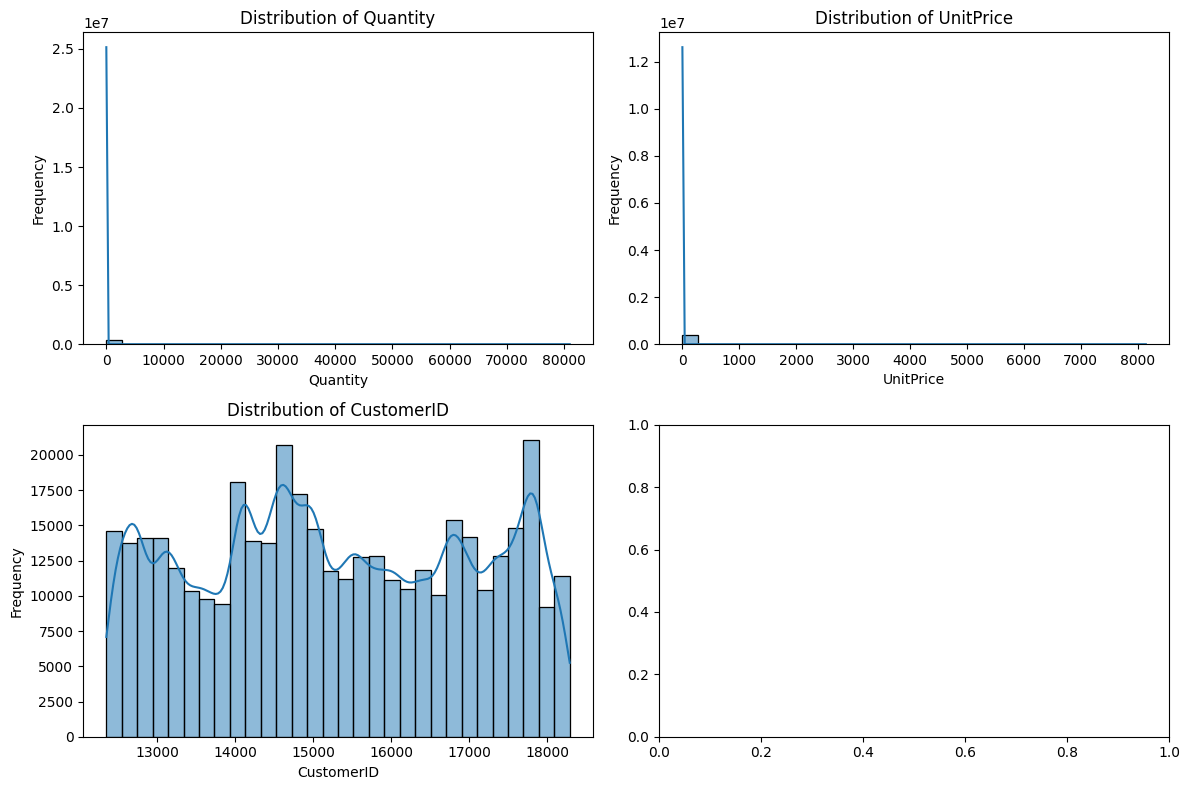

In [8]:
numeric_cols = data.select_dtypes(include='number').columns
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.flatten()

for i, col in enumerate(numeric_cols[:4]): 
    sns.histplot(data[col], kde=True, bins=30, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [9]:

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

ref_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Step 2: Calculate recency
recency = data.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (ref_date - x).days)

recency = recency.reset_index()
recency.columns = ['CustomerID', 'Recency']


In [10]:
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency = frequency.rename(columns={'InvoiceNo': 'Frequency'})


In [11]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Calculate total spent per customer
monetary = data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary = monetary.rename(columns={'TotalPrice': 'Monetary'})


In [12]:
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')


In [13]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


<Axes: >

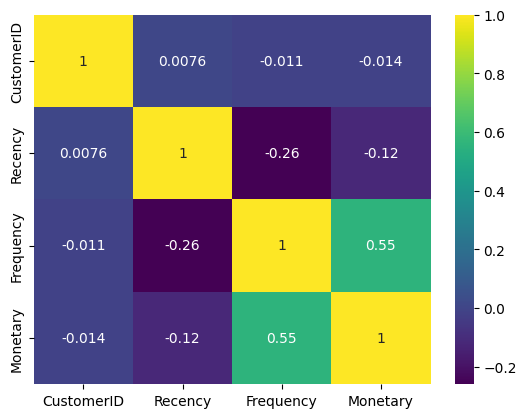

In [14]:
cor=rfm.corr()
sns.heatmap(cor,annot=True,cmap='viridis')

array([[<Axes: title={'center': 'CustomerID'}>,
        <Axes: title={'center': 'Recency'}>],
       [<Axes: title={'center': 'Frequency'}>,
        <Axes: title={'center': 'Monetary'}>]], dtype=object)

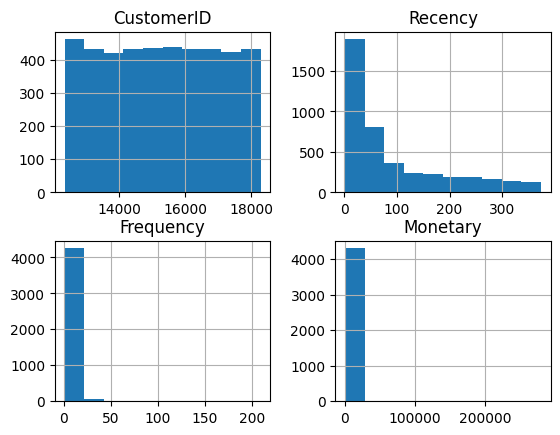

In [15]:
rfm.hist()

In [16]:
from sklearn.preprocessing import StandardScaler

rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]



In [18]:
# z-score
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

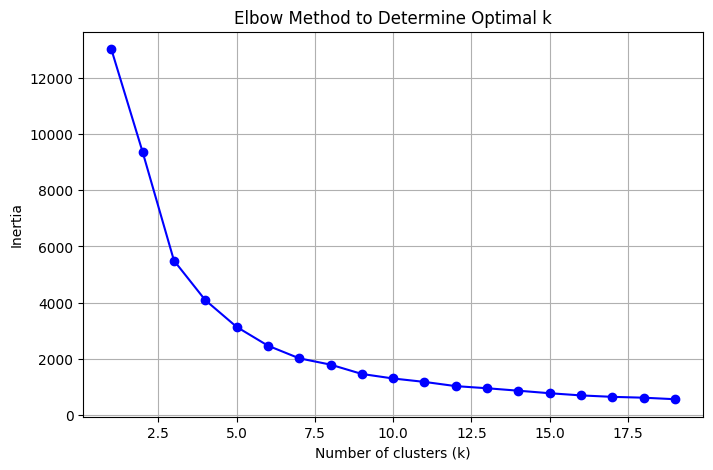

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()


In [35]:
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [36]:
rfm.groupby('Cluster').mean().round(2)

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15290.41,43.81,3.69,1358.77
1,15346.23,248.47,1.55,480.42
2,14751.00,1.50,135.83,58381.12
3,15220.39,15.72,22.30,13534.00
4,15535.83,7.67,42.83,190863.46


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


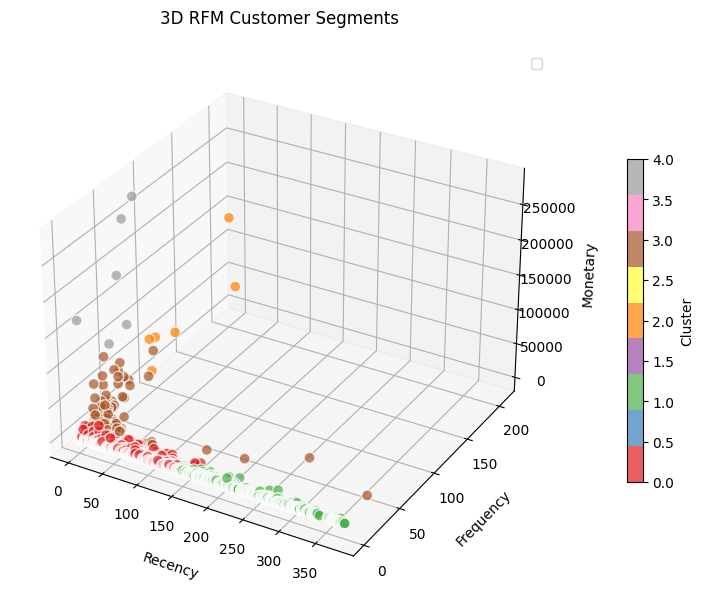

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot RFM points with color by cluster
sc = ax.scatter(
    rfm['Recency'], 
    rfm['Frequency'], 
    rfm['Monetary'], 
    c=rfm['Cluster'], 
    cmap='Set1', 
    s=60, 
    alpha=0.7,
    edgecolors='w'
)

ax.set_xlabel('Recency', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.set_zlabel('Monetary', labelpad=10)
ax.set_title('3D RFM Customer Segments', pad=20)


plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.1, label='Cluster')
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import silhouette_score

score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {score:.2f}')


Silhouette Score: 0.62


In [40]:
pred = kmeans.predict(rfm_scaled)
rfm_cluster =rfm_data.copy()
rfm_cluster['cluster'] = pred

In [41]:
rfm_cluster

,Recency,Frequency,Monetary,cluster
0,326,1,77183.60,3
1,2,7,4310.00,0
2,75,4,1797.24,0
3,19,1,1757.55,0
4,310,1,334.40,1
...,...,...,...,...
4333,278,1,180.60,1
4334,181,1,80.82,1
4335,8,2,178.05,0
4336,4,16,2094.88,3


<Axes: xlabel='Recency', ylabel='Frequency'>

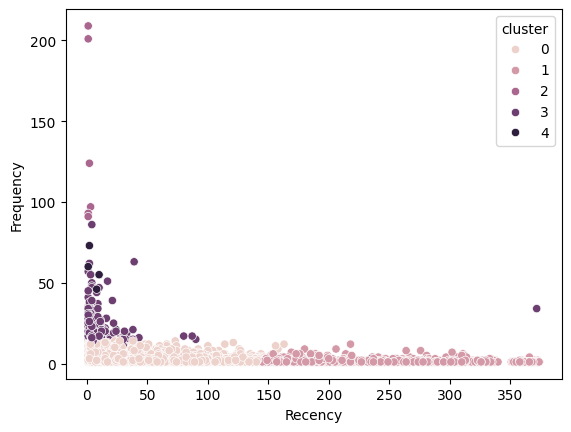

In [42]:
sns.scatterplot(data=rfm_cluster, x="Recency", y="Frequency",hue='cluster')

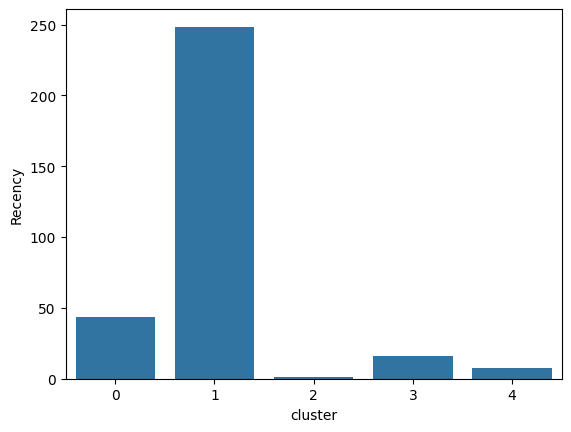

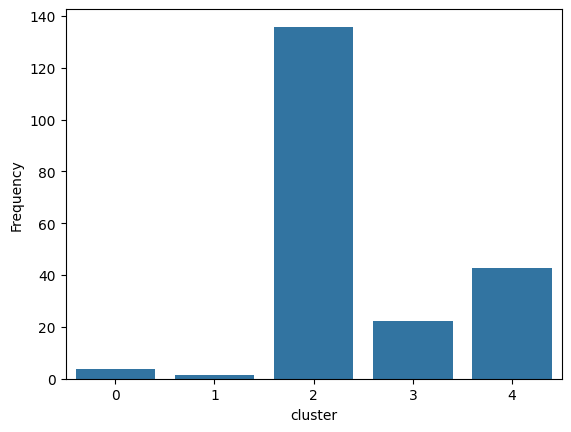

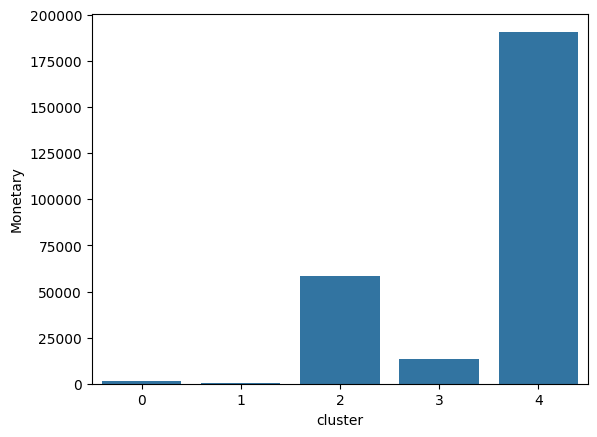

In [43]:
list1 = ['Recency','Frequency','Monetary']
avg_df = rfm_cluster.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()